# Finding Most Optimal Temperature Scaling for Model Calibration
- Both the test and stress test datasets are compared to reflect original data and augmented data
- The optimal softmax temperature selected is used for permanently calibrating the disease detection model
- The Expected Calibration Error (ECE) of the model was also plotted in a graph.

Found 63 images belonging to 4 classes.
Found 63 images belonging to 4 classes.
Found 252 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Original dataset Temperature: 2.035 | ECE: 0.0448



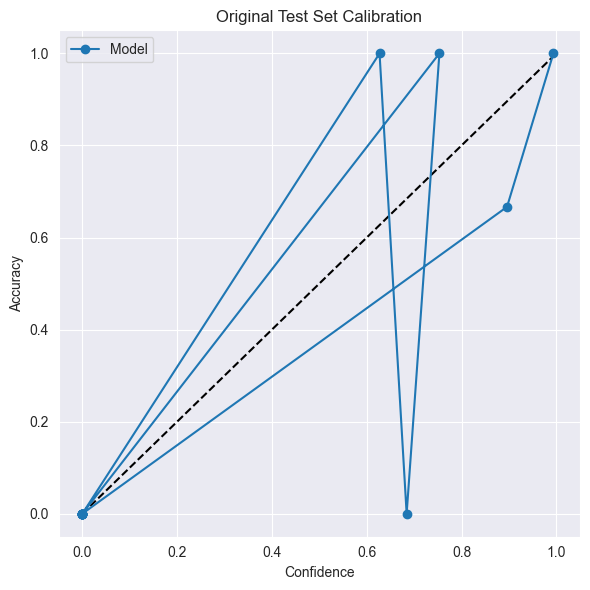

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Crop and Padded dataset Temperature: 1.822 | ECE: 0.0505



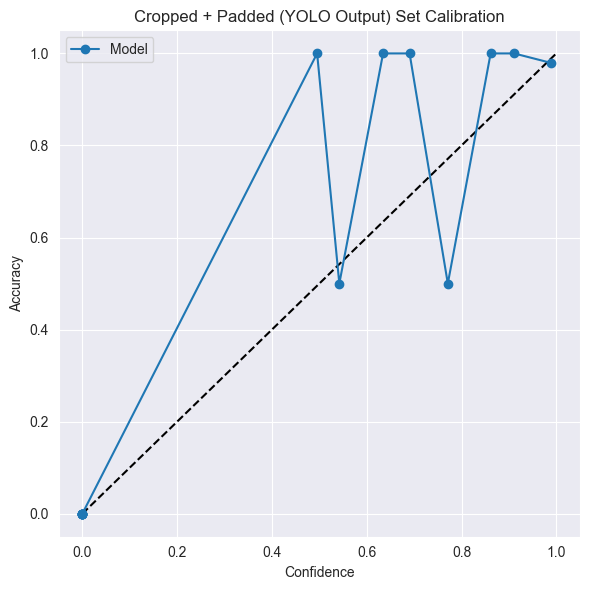

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Augmented dataset Temperature: 2.001 | ECE: 0.0215



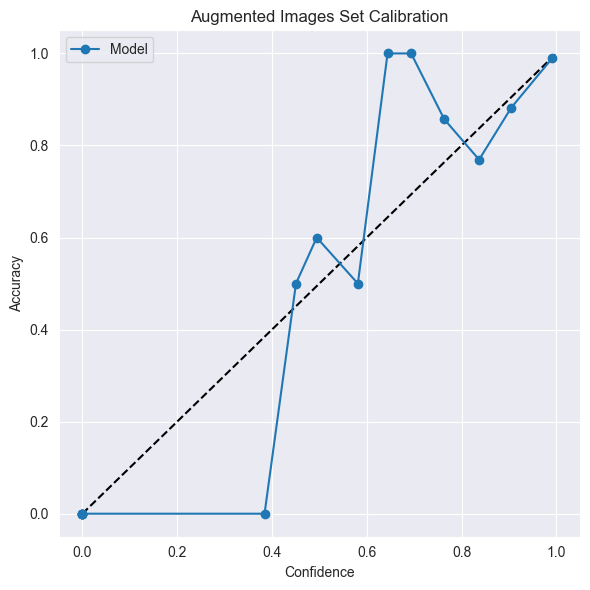

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.optimize import minimize

# Load model
model = load_model("model/VGG19_model.keras")

# Image data generators
val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Shift width by up to 20%
    height_shift_range=0.2, # Shift height by up to 20%
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Random zooming
    horizontal_flip=True,   # Flip images horizontally
    brightness_range=[0.8, 1.2]  # Adjust brightness randomly
)

ori_generator = val_datagen.flow_from_directory(
    r"D:\Suvan's Projects\FYP\EditAugment\test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

cropPad_generator = train_datagen.flow_from_directory(
    r"D:\Suvan's Projects\FYP\Masked_Split\test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

aug_generator = train_datagen.flow_from_directory(
    r"D:\Suvan's Projects\FYP\EditAugment\stressTest",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# --- Calibration + ECE Functions ---

def calibrate_temperature(model, generator):
    logits, labels = [], []

    for batch_x, batch_y in generator:
        pred = model.predict(batch_x)
        logits.append(np.log(pred + 1e-8))
        labels.append(batch_y)
        if len(logits) * generator.batch_size >= generator.n:
            break

    logits = np.vstack(logits)
    labels = np.vstack(labels)

    def temperature_scaled_loss(T):
        T = T[0]
        scaled_logits = logits / T
        exp_logits = np.exp(scaled_logits - np.max(scaled_logits, axis=1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        loss = -np.sum(labels * np.log(probs + 1e-8)) / len(probs)
        return loss

    result = minimize(temperature_scaled_loss, x0=[1.0], bounds=[(0.5, 10.0)], method='L-BFGS-B')
    return result.x[0], logits, labels

def apply_temperature_scaling(logits, temperature):
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probs

def compute_ece(probs, labels, n_bins=15): # ECE = Expected Calibration Error
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    actuals = np.argmax(labels, axis=1)

    ece = 0.0
    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            acc_in_bin = np.mean(predictions[in_bin] == actuals[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(acc_in_bin - avg_conf_in_bin) * prop_in_bin

    return ece

def plot_reliability_diagram(probs, labels, title="Reliability Diagram", n_bins=15):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    actuals = np.argmax(labels, axis=1)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    accuracies, confidences_avg = [], []

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)

        if np.any(in_bin):
            accuracies.append(np.mean(predictions[in_bin] == actuals[in_bin]))
            confidences_avg.append(np.mean(confidences[in_bin]))
        else:
            accuracies.append(0)
            confidences_avg.append(0)

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(confidences_avg, accuracies, marker='o', label="Model")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Original set calibration
val_temp, val_logits, val_labels = calibrate_temperature(model, ori_generator)
val_probs = apply_temperature_scaling(val_logits, val_temp)
val_ece = compute_ece(val_probs, val_labels)
print("===================================================")
print(f"Original dataset Temperature: {val_temp:.3f} | ECE: {val_ece:.4f}")
print("===================================================\n")
plot_reliability_diagram(val_probs, val_labels, title="Original Test Set Calibration")

# Crop and padded set calibration
test_temp, test_logits, test_labels = calibrate_temperature(model, cropPad_generator)
test_probs = apply_temperature_scaling(test_logits, test_temp)
test_ece = compute_ece(test_probs, test_labels)
print("===================================================")
print(f"Crop and Padded dataset Temperature: {test_temp:.3f} | ECE: {test_ece:.4f}")
print("===================================================\n")
plot_reliability_diagram(test_probs, test_labels, title="Cropped + Padded (YOLO Output) Set Calibration")

# Stress test calibration
stress_temp, stress_logits, stress_labels = calibrate_temperature(model, aug_generator)
stress_probs = apply_temperature_scaling(stress_logits, stress_temp)
stress_ece = compute_ece(stress_probs, stress_labels)
print("===================================================")
print(f"Augmented dataset Temperature: {stress_temp:.3f} | ECE: {stress_ece:.4f}")
print("===================================================\n")
plot_reliability_diagram(stress_probs, stress_labels, title="Augmented Images Set Calibration")
